In [179]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skimage.color import rgb2hed
from scipy.stats import entropy
from sklearn.decomposition import PCA
import seaborn as sns

In [146]:
D = h5py.File('breast.h5', 'r')
X,Y,P = np.array(D['images']),np.array(D['counts']),np.array(D['id'])

In [149]:
avg_brown =[]
for im in X:
    hed_img = rgb2hed(im)
    avg = np.mean(hed_img[:,:,2])
    print(avg)
    break

-0.3799775017875077


In [3]:
# Split to train and test sets
split_position = np.where(P==14)[0][0]
train_x = X[0:split_position]
train_y = Y[0:split_position]
test_x = X[split_position:]
test_x = Y[split_position:]

# Question 1

## Q1 i)

In [4]:
num_train = len(train_x)
num_test = len(train_y)
print("Train:",num_train,"Test:",num_test)

Train: 5841 Test: 5841


## Q1 ii)

In [5]:
def get_image(class_val, x_data = train_x, y_data=train_y, offset = 0):
    try:
        ret = x_data[np.where(Y==class_val)[0][0 + offset]]
    except:
        ret = []
    return ret

/dcs/16/u1600920/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/dcs/16/u1600920/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


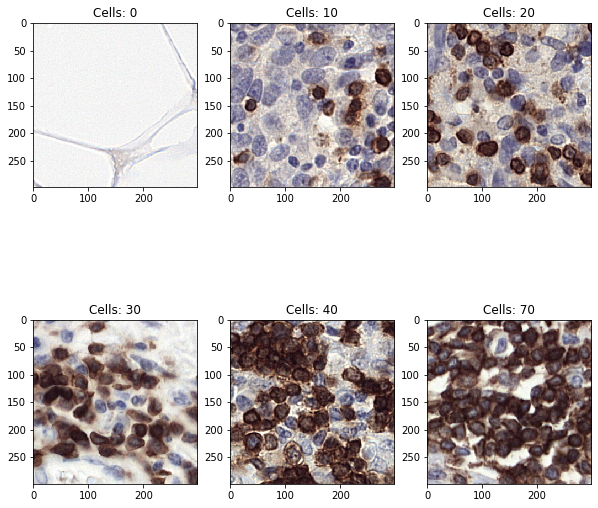

In [18]:
# Plots 6 Different images in 
m = 2
n = 3
fig, ax = plt.subplots(m,n,figsize=(10,10))

num_cells = 0
for i in range(m):
    for j in range(n):
        image = get_image(num_cells)
        while image == [] and num_cells<train_y.max():
            num_cells += 1
            image = get_image(num_cells)
        
        if image != []:
            ax[i,j].imshow(image)
            ax[i,j].title.set_text("Cells: " + str(num_cells))
        num_cells+=10
plt.show(fig)


## Q1 iii)

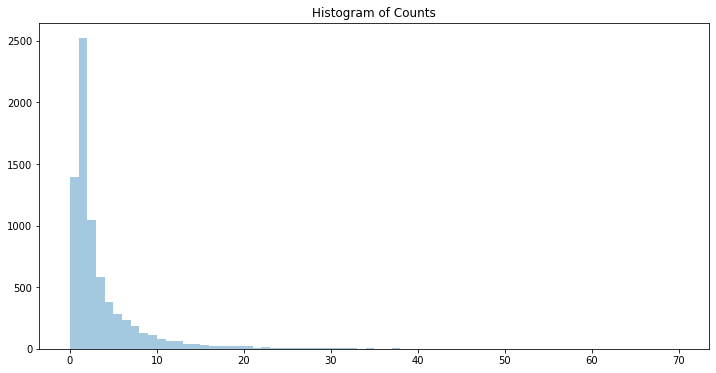

In [45]:
plt.figure(figsize=(12,6))
plt.title("Histogram of Counts")
sns.distplot(Y, kde=False, bins=70)
plt.show()

In [69]:
def get_num_images(bucket: tuple,data=Y):
    return len(data [ np.logical_and(data>=bucket[0],data<=bucket[1]) ])

total = 0
for bucket in [(0,0),(1,5),(6,10),(11,20),(21,50),(51,200),(201, 3000)]:
    num = get_num_images(bucket)
    total +=num
    print("In Bin", bucket, "there were", num, "images")


In Bin (0, 0) there were 1397 images
In Bin (1, 5) there were 4811 images
In Bin (6, 10) there were 736 images
In Bin (11, 20) there were 356 images
In Bin (21, 50) there were 103 images
In Bin (51, 200) there were 1 images
In Bin (201, 3000) there were 0 images


## Q1 iv)

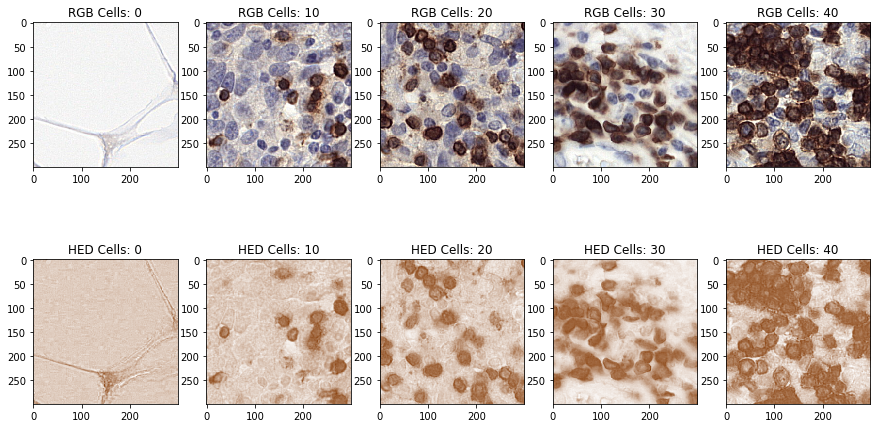

In [86]:
num_images = 5
multiplier = 10

# Creating lists of rgb and hed images
images = [get_image(i*multiplier) for i in range(num_images)]
hed_images = [rgb2hed(img) for img in images]
# Creating brown colourmap
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])

# Plotting Graph 
fig, ax = plt.subplots(2, num_images, figsize=(num_images * 3,8))

for i in range(num_images):
    ax[0,i].imshow(images[i])
    ax[0,i].title.set_text("RGB Cells: " + str(i * multiplier))

    ax[1,i].imshow(hed_images[i][:,:,2], cmap=cmap_dab)
    ax[1,i].title.set_text("HED Cells: " + str(i * multiplier))


## Q1 v)

In [45]:
def get_brown_channel_from_rgb(img):
    return rgb2hed(img)[:,:,2]

In [130]:
# Function that generates 2 lists containing the average of the brown channel for each image along with the number of cells that the image has
def get_average_brown_channel(x_data = X, y_data = Y, subsample = False):
    length = len(x_data)
    num_cells = [ y_data[i] for i in range(length)]
    avg_values = [rgb2hed(x_data[i])[:,:,2].mean() for i in range(length)]
    return (num_cells,avg_values)

In [131]:
num_cells, avg_values = get_average_brown_channel()

In [145]:
rgb2hed(X[0])[:,:,2].mean()

-0.3799775017875077

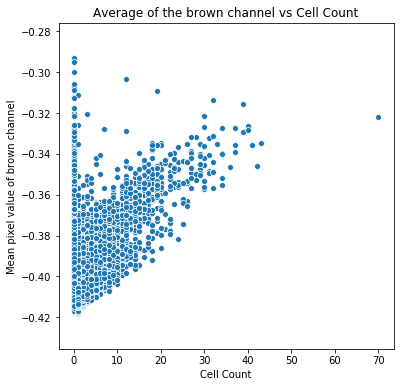

In [132]:
plt.figure(figsize=(6,6))
plt.title("Average of the brown channel vs Cell Count")
sns.scatterplot(num_cells,avg_values)
plt.xlabel("Cell Count")
plt.ylabel("Mean pixel value of brown channel")
plt.show()

It wont be too useful. There is a slight relationship with a higher cell count leading to an overall higher mean pixel density but there is a wide variance in values that would make it hard to use in a regression model.

## Q1 vi)

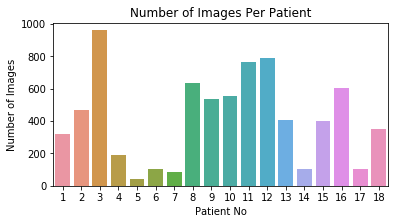

In [136]:
person, img_count = np.unique(P, return_counts=True)
plt.figure(figsize=(6,3))
plt.title("Number of Images Per Patient")
sns.barplot(person, img_count)
plt.xlabel("Patient No")
plt.ylabel("Number of Images")
plt.show()

As can be seen in the bar chart above there is a wide variety in the number of images per patient. This may lead the model to overfit to one patient such as in this case patient 3. 
It will most likely affect the model.

## Q1 vii)

Based on the warpedness of the dataset I'd go for auc-roc.
Dataset is warped in terms of cell count and in terms of which patient the image was taken from.
AUC-ROC is more robust than accuracy.
What about AUC-PR??

# Q2 i)

In [118]:
test_image = train_x[0]

In [79]:
def apply_function_brgb(img, func):
    brown = get_brown_channel_from_rgb(img)
    red, green, blue = [img[:,:,i] for i in range(3)]
    return [func(x) for x in [brown, red, green, blue]]

In [80]:
def flatten_entropy(img):
    return entropy(img.ravel())

In [167]:
def get_mean_top_3_hist_vals(img):
    u, count = np.unique(img.ravel(), return_counts=True)      
    return u[np.argsort(-count)][0:3].mean()

In [190]:
def calculate_features(img):
    brown = get_brown_channel_from_rgb(img)
    arr = np.zeros((299,299,4))
    arr[:,:,0:3] = img
    arr[:,:,3] = brown
    ret = []
    for i in range(4):
        channel = arr[:,:,i]
        m = np.mean(channel)
        v = np.var(channel)
        e = flatten_entropy(channel)
        h = get_mean_top_3_hist_vals(channel)
        ret.extend([m,v,e,h])
    return ret

In [154]:
# def get_pca_score(img):
#     pca = PCA(n_components=1)
#     pca.fit(test_image[:,:,2])
#     return pca.score(test_image[:,:,2])

-1484.2964581319047

In [172]:
final 
for img in X:
    print(calculate_features(x))
    break

[[240.63026140647196, 267.3107156607972, 11.398209376386164, 246.0], [239.81865974653527, 345.82197192213545, 11.397262549459935, 245.0], [240.89598550351786, 328.53822406010244, 11.397471909314575, 246.0], [-0.41370184684668154, 0.0001342387888886738, 11.400469610233554, -0.4167704910682179]]


In [194]:
data = []
count =0
for img in train_x:
    features = calculate_features(img)
    if count%750 == 0:
        print (10)
    data.append(features)
    count+=1

10
10
10
10
10
10
10
10
10
10


In [ ]:
np.histogram

In [213]:
channels = ["Red","Green","Blue","Brown"]
features = ["Mean","Var","Entropy","Histogram"]
columns = [x + " " + y for x in channels for y in features]
df = pd.DataFrame(data=data,columns=columns)
df["Cell Count"] = Y

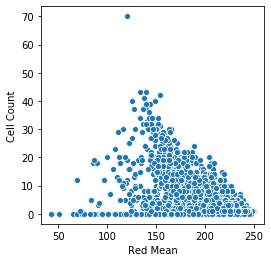

In [215]:
plt.figure(figsize=(4,4))
sns.scatterplot(x="Red Mean",y="Cell Count", data=df)

In [207]:
calculate_features(X[0])

[179.0747083365958,
 1921.4295144687405,
 11.367848794959706,
 204.0,
 170.9491169002584,
 2212.668085734827,
 11.358190087584395,
 202.0,
 178.14088209304145,
 1596.1474098727995,
 11.372237658487851,
 199.66666666666666,
 -0.3799775017875077,
 0.0005931334288957775,
 11.398742842865293,
 -0.3930106202629437]